# [과제 2] 회귀분석
### - Ch 1, Ch 2를 토대로 자유롭게 회귀분석과 회귀진단을 진행해주세요.
### - 주석으로 설명 및 근거 자세하게 달아주시면 감사하겠습니다. :)

In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

import warnings
warnings.filterwarnings(action='ignore')

plt.style.use('seaborn')
plt.rc('font', family='DejaVu Sans')
plt.rc('axes', unicode_minus=False)

# Data 

: 중고차 가격 예측

데이터 출처 : https://www.kaggle.com/avikasliwal/used-cars-price-prediction 

< y > 
* **Price** : The price of the used car in INR Lakhs.



< X > 
* Name : The brand and model of the car
* Location : The location in which the car is being sold or is available for purchase.
* Year : The year or edition of the model.
* Kilometers_Driven : The total kilometres driven in the car by the previous owner(s) in KM.
* Fuel_Type : The type of fuel used by the car. (Petrol, Diesel, Electric, CNG, LPG)
* Transmission : The type of transmission used by the car. (Automatic / Manual)
* Owner_Type : Whether the ownership is Firsthand, Second hand or other.
* Mileage : The standard mileage offered by the car company in kmpl or km/kg
* Engine : The displacement volume of the engine in CC.
* Power : The maximum power of the engine in bhp.
* Seats : The number of seats in the car.
* New_Price : The price of a new car of the same model.

1. 구조
* 6019 X 14
* 관측치 : 6019개
* 설명 변수 (X) : 13개 
* 반응 변수 (Y) : 1개 

In [2]:
# Load Data 
data = pd.read_csv("assignment2_data.csv")
data.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [3]:
data.shape

(6019, 14)

# Data Preprocessing

Mileage, Engine, Power 데이터 뒤에 붙은 단위를 삭제함.

In [4]:
data['Mileage'] = data['Mileage'].str.replace(' km/kg', '')
data['Mileage'] = data['Mileage'].str.replace(' kmpl', '')

data['Engine'] = data['Engine'].str.replace(' CC', '')

data['Power'] = data['Power'].str.replace(' bhp', '')
data['Power'] = data['Power'].apply(lambda x: None if x == "null" else x)
data['Power'] = data['Power'].apply(lambda x: None if x == "" else x)

data['Mileage'] = pd.to_numeric(data['Mileage'])
data['Engine'] = pd.to_numeric(data['Engine'])
data['Power'] = pd.to_numeric(data['Power'])

In [5]:
data['Company'] = data['Name'].str.split().str[0]

In [6]:
data.drop('Name', axis=1, inplace=True)

Unnamed: 0은 필요하지 않은 컬럼이기에 제거해줌.

In [7]:
data.drop('Unnamed: 0', axis=1, inplace=True)

## 1. 결측치 확인 및 제거

In [8]:
data.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Company
0,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,NaN,1.75,Maruti
1,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,NaN,12.50,Hyundai
2,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,8.61 Lakh,4.50,Honda
3,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,NaN,6.00,Maruti
4,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,NaN,17.74,Audi


In [9]:
data.isnull().sum()

Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                 143
Seats                  42
New_Price            5195
Price                   0
Company                 0
dtype: int64

`New_price`는 총 데이터 6,019개 중 결측치 5,195개이므로 `New_Price` 컬럼은 삭제함. 

나머지 결측치는 평균으로 채움.

In [10]:
data.drop('New_Price', axis=1, inplace=True)

In [11]:
data = data.fillna(data.mean())

In [12]:
data.isnull().sum()

Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
Company              0
dtype: int64

## 2. 이상치 확인 및 제거/대체

In [13]:
data.describe()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price
count,6019.000000,6.019000e+03,6019.000000,6019.000000,6019.000000,6019.000000,6019.000000
mean,2013.358199,5.873838e+04,18.134961,1621.276450,113.253050,5.278735,9.479468
std,3.269742,9.126884e+04,4.581528,599.553865,53.231019,0.806012,11.187917
min,1998.000000,1.710000e+02,0.000000,72.000000,34.200000,0.000000,0.440000
25%,2011.000000,3.400000e+04,15.170000,1198.000000,78.000000,5.000000,3.500000
50%,2014.000000,5.300000e+04,18.150000,1493.000000,98.600000,5.000000,5.640000
75%,2016.000000,7.300000e+04,21.100000,1969.000000,138.030000,5.000000,9.950000
max,2019.000000,6.500000e+06,33.540000,5998.000000,560.000000,10.000000,160.000000


**Kilometers_Driven**

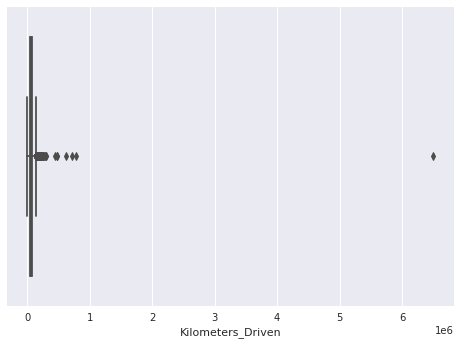

In [14]:
sns.boxplot('Kilometers_Driven', data=data)
plt.show()

2017년식인데 주행거리가 650만km이기에 이상치라고 판단하여 제거함.

In [15]:
idx_num_1 = data[data['Kilometers_Driven'] == 6.500000e+06].index
data = data.drop(idx_num_1)

**Mileage**

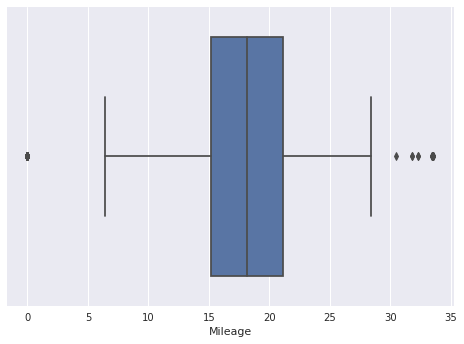

In [16]:
sns.boxplot('Mileage', data=data)
plt.show()

In [17]:
data[data['Mileage'] == 0]

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Company
14,Pune,2012,85000,Diesel,Automatic,Second,0.0,2179.00000,115.00000,5.000000,17.50,Land
67,Coimbatore,2019,15369,Diesel,Automatic,First,0.0,1950.00000,194.00000,5.000000,35.67,Mercedes-Benz
79,Hyderabad,2005,87591,Petrol,Manual,First,0.0,1086.00000,113.25305,5.000000,1.30,Hyundai
194,Ahmedabad,2007,60006,Petrol,Manual,First,0.0,1621.27645,113.25305,5.278735,2.95,Honda
229,Bangalore,2015,70436,Diesel,Manual,First,0.0,1498.00000,99.00000,5.278735,3.60,Ford
...,...,...,...,...,...,...,...,...,...,...,...,...
5647,Mumbai,2001,227000,Diesel,Manual,Fourth & Above,0.0,2446.00000,113.25305,8.000000,2.20,Toyota
5875,Ahmedabad,2019,4000,Diesel,Automatic,First,0.0,1950.00000,194.00000,5.000000,35.00,Mercedes-Benz
5943,Chennai,2002,75000,Diesel,Manual,First,0.0,2112.00000,113.25305,6.000000,1.70,Mahindra
5972,Mumbai,2008,65000,Petrol,Manual,Second,0.0,1086.00000,62.00000,5.000000,1.39,Hyundai


Mileage가 0인 데이터가 68개로 결측치로 판단하고 데이터를 제거함.

In [18]:
idx_num_2 = data[data['Mileage'] == 0].index
data = data.drop(idx_num_2)

**Seats**

In [19]:
data[data['Seats'] == 0]

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Company
3999,Hyderabad,2012,125000,Petrol,Automatic,First,10.5,3197.0,113.25305,0.0,18.0,Audi


구글링을 통해 5개로 값을 바꿈.

In [20]:
data['Seats'] = data['Seats'].replace(0,5)

## 3. Scaling

**Price(Target)**

<AxesSubplot:>

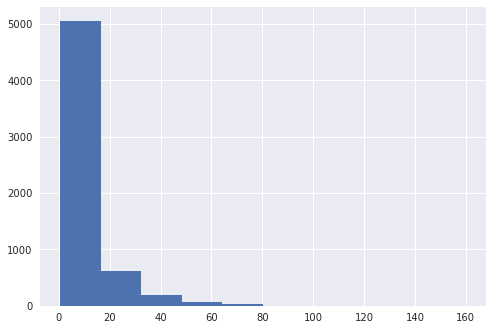

In [21]:
data['Price'].hist()

왼쪽으로 치우쳐져 있는 것을 확인할 수 있음.

In [22]:
data['log_price'] = np.log(data['Price'])

<AxesSubplot:>

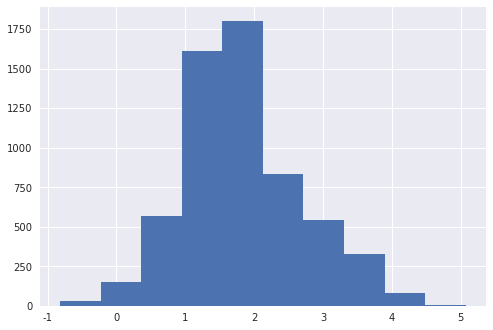

In [23]:
data['log_price'].hist()

log를 취해준 결과 정규분포 형태를 띄는 것을 알 수 있음.

In [24]:
data.drop('Price', axis=1, inplace=True)

**Kilometers_Driven**

<AxesSubplot:>

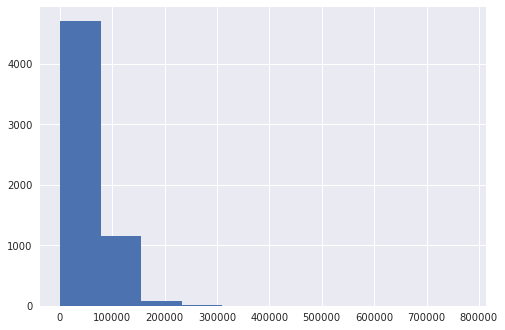

In [25]:
data['Kilometers_Driven'].hist()

왼쪽으로 치우쳐져 있는 것을 확인할 수 있음.

In [26]:
data['log_Kilometers_Driven'] = np.log(data['Kilometers_Driven'])

<AxesSubplot:>

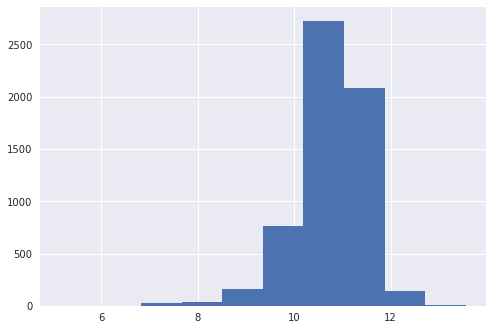

In [27]:
data['log_Kilometers_Driven'].hist()

약간 오른쪽으로 치우쳤지만 log 변환 후 더 정규분포 형태와 비슷해짐.

In [28]:
data.drop('Kilometers_Driven', axis=1, inplace=True)

**Engine**

<AxesSubplot:>

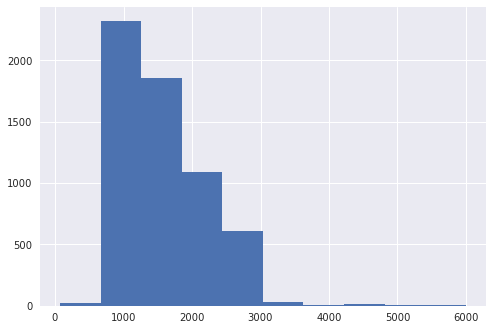

In [29]:
data['Engine'].hist()

왼쪽으로 치우쳐져 있는 것을 확인할 수 있음.

In [30]:
data['log_Engine'] = np.log(data['Engine'])

<AxesSubplot:>

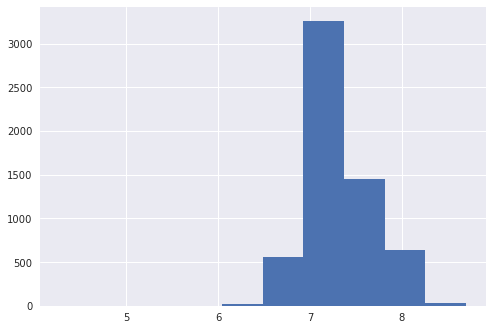

In [31]:
data['log_Engine'].hist()

약간 오른쪽으로 치우쳤지만 log 변환 후 더 정규분포 형태와 비슷해짐.

In [32]:
data.drop('Engine', axis=1, inplace=True)

**Power**

<AxesSubplot:>

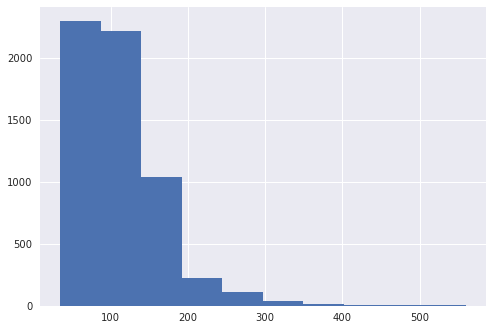

In [33]:
data['Power'].hist()

왼쪽으로 치우쳐져 있는 것을 확인할 수 있음.

In [34]:
data['log_Power'] = np.log(data['Power'])

<AxesSubplot:>

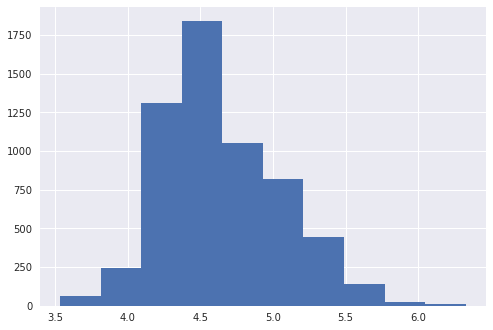

In [35]:
data['log_Power'].hist()

log를 취해준 결과 정규분포 형태를 띄는 것을 알 수 있음.

In [36]:
data.drop('Power', axis=1, inplace=True)

**Mileage**

<AxesSubplot:>

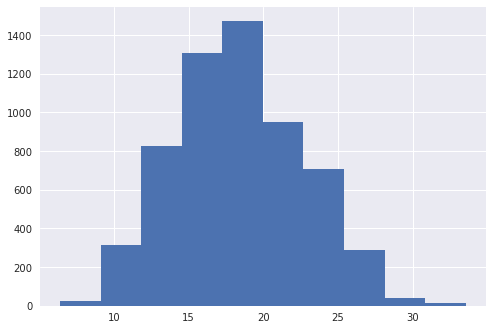

In [37]:
data['Mileage'].hist()

정규분포 형태이기 때문에 로그변환은 해주지 않음

In [38]:
data.describe()

,Year,Mileage,Seats,log_price,log_Kilometers_Driven,log_Engine,log_Power
count,5950.000000,5950.000000,5950.000000,5950.000000,5950.000000,5950.000000,5950.000000
mean,2013.405714,18.342581,5.281069,1.828100,10.755178,7.330619,4.637996
std,3.220496,4.175012,0.803033,0.866112,0.712693,0.338320,0.412315
min,1998.000000,6.400000,2.000000,-0.820981,5.141664,4.276666,3.532226
25%,2012.000000,15.300000,5.000000,1.252763,10.431303,7.088409,4.343805
50%,2014.000000,18.200000,5.000000,1.731656,10.878047,7.308543,4.591071
75%,2016.000000,21.100000,5.000000,2.294048,11.197903,7.584773,4.927471
max,2019.000000,33.540000,10.000000,5.075174,13.560618,8.699181,6.327937


Year를 제외하고 변수의 범위가 비슷함을 알 수 있음.

### 범주형 변수 더미로 변환

* 더미변수는 범주형 변수를 연속형 변수로 변환한 것, 연속형 변수 "스럽게" 만든 것
* 회귀분석 계열은 설명변수가 연속형 변수여야지 사용할 수 있는 분석임. 따라서 만약 설명변수 중에 범주형 변수가 섞여 있다면, 그 변수를 더미변수로 변환 즉,연속형 변수스럽게 만들어서 회귀분석을 진행해야 함.

In [39]:
def dummy(feature_name):
    return pd.get_dummies(data[feature_name], prefix=feature_name, drop_first=True)

In [40]:
Fuel_dummy = dummy('Fuel_Type')
Transmission_dummy = dummy('Transmission')
Owner_dummy = dummy('Owner_Type')
Year_dummy = dummy('Year')
Seat_dummy = dummy('Seats')
Company_dummy = dummy('Company')

In [41]:
data = pd.concat([data, Fuel_dummy, Transmission_dummy, Owner_dummy, Year_dummy,
                 Seat_dummy, Company_dummy], axis=1)

In [42]:
data = data.drop(['Location', 'Fuel_Type', 'Transmission', 'Owner_Type','Year', 'Seats', 'Company'], axis=1)

### 데이터 간의 상관성 파악

In [43]:
num_feature = ['log_Kilometers_Driven', 'Mileage', 'log_Engine', 'log_Power', 'log_price']

In [44]:
data[num_feature].corr()

,log_Kilometers_Driven,Mileage,log_Engine,log_Power,log_price
log_Kilometers_Driven,1.000000,-0.131704,0.177130,0.049939,-0.202739
Mileage,-0.131704,1.000000,-0.639856,-0.573092,-0.302764
log_Engine,0.177130,-0.639856,1.000000,0.878213,0.691333
log_Power,0.049939,-0.573092,0.878213,1.000000,0.774588
log_price,-0.202739,-0.302764,0.691333,0.774588,1.000000


<AxesSubplot:>

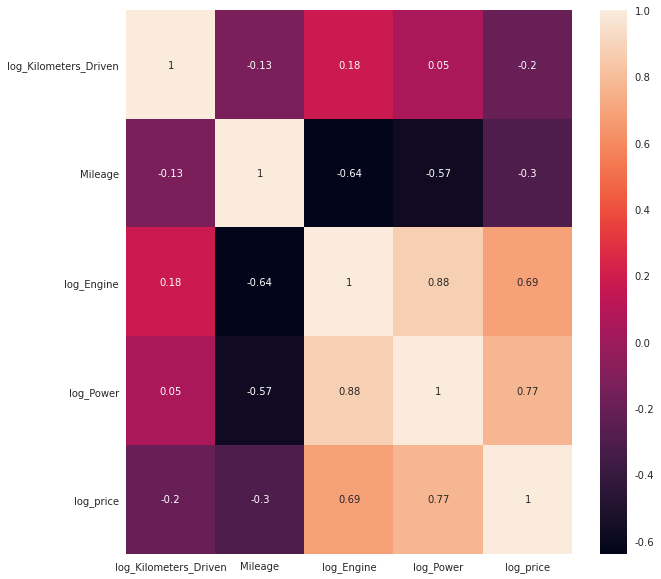

In [45]:
plt.figure(figsize=(10,10))
sns.heatmap(data=data[num_feature].corr(), annot=True)

`log_price`와 `log_Engine`, `log_Power`이 상관관계가 높은 것을 확인할 수 있음.

# 회귀분석

In [46]:
import scipy as sp
import scipy.stats as stats

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## train / test set 나누기

In [47]:
target = data['log_price']
feature = data.drop(['log_price'], axis=1)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=10)

## 선형회귀 모델 구축

statsmodels의 OLS를 이용해 선형회귀분석 시행
* OLS : 잔차제곱합(RSS)를 최소화하는 회귀 계수를 구하기

In [49]:
import statsmodels.api as sm

model = sm.OLS(target, feature)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              log_price   R-squared (uncentered):                   0.986
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                              5765.
Date:                Thu, 03 Feb 2022   Prob (F-statistic):                        0.00
Time:                        16:40:56   Log-Likelihood:                         -11.079
No. Observations:                5950   AIC:                                      162.2
Df Residuals:                    5880   BIC:                                      630.5
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Mileage                      -0.0167      0.001    -11.233      0.000      -0.020      -0.014
log_Kilometers_Driven        -0.0485      0.006     -8.175      0.000      -0.060      -0.037
log_Engine                    0.1650      0.028      5.948      0.000       0.111       0.219
log_Power                     0.7239      0.022     32.640      0.000       0.680       0.767
Fuel_Type_Diesel              0.1516      0.034      4.500      0.000       0.086       0.218
Fuel_Type_Electric            1.4839      0.180      8.260      0.000       1.132       1.836
Fuel_Type_LPG                 0.0279      0.084      0.332      0.740      -0.137       0.193
Fuel_Type_Petrol             -0.1043      0.034     -3.064      0.002      -0.171      -0.038
Transmission_Manual          -0.1241      0.011    -11.742      0.000      -0.145      -0.103
Owner_Type_Fourth & Above     0.0745      0.087      0.855      0.393      -0.096       0.245
Owner_Type_Second            -0.0526      0.009     -5.689      0.000      -0.071      -0.034
Owner_Type_Third             -0.1331      0.025     -5.301      0.000      -0.182      -0.084
Year_1999                    -0.2173      0.208     -1.046      0.296      -0.625       0.190
Year_2000                     0.0314      0.170      0.185      0.854      -0.302       0.365
Year_2001                    -0.2208      0.154     -1.438      0.151      -0.522       0.080
Year_2002                     0.0675      0.138      0.489      0.625      -0.203       0.338
Year_2003                    -0.1433      0.129     -1.115      0.265      -0.395       0.109
Year_2004                     0.1269      0.126      1.009      0.313      -0.120       0.374
Year_2005                    -0.0077      0.121     -0.064      0.949      -0.245       0.230
Year_2006                     0.3372      0.120      2.810      0.005       0.102       0.572
Year_2007                     0.4621      0.118      3.905      0.000       0.230       0.694
Year_2008                     0.5404      0.118      4.576      0.000       0.309       0.772
Year_2009                     0.6536      0.118      5.551      0.000       0.423       0.884
Year_2010                     0.7790      0.117      6.643      0.000       0.549       1.009
Year_2011                     0.9066      0.117      7.742      0.000       0.677       1.136
Year_2012                     1.0627      0.117      9.082      0.000       0.833       1.292
Year_2013                     1.1749      0.117     10.048      0.000       0.946       1.404
Year_2014                     1.3027      0.117     11.144      0.000       1.074       1.532
Year_2015                     1.4317      0.117     12.236      0.000 

$R^2$의 값이 0.986으로 모델의 설명력이 높은 것을 확인할 수 있음. $Adj.R^2$ 또한 0.985로 높음. F-statistic은 5736으로 이 모형이 통계적으로 유의미함을 알 수 있음.

P값을 보면 Year_1999~2005, Owner_Type_Fourth & Above, Fuel_Type_LPG 변수를 제외하고는 통계적으로 유의미함을 알 수 있음.	

Durbin-Watson 통계량이 1.989로 2에 가까워 오차항의 독립성이 만족함을 알 수 있음.

# 회귀진단

In [50]:
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train, axis=1)
model_trained = model.fit()

## 1. 선형성(설명변수와 반응변수 간 선형 관계) 판단

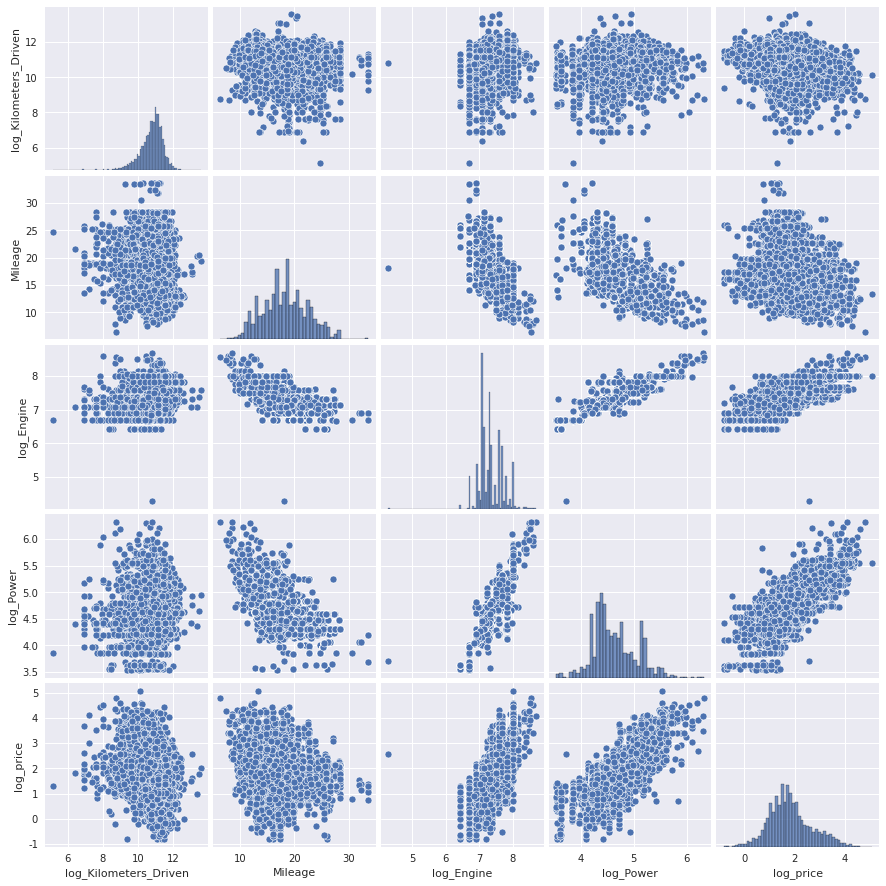

In [51]:
sns.pairplot(data[num_feature])

수치형 변수만을 봤을 때 서로 선형성이 존재함을 알 수 있음.

## 2. 2. 정규성(오차가 정규분포를 따르는지) 판단

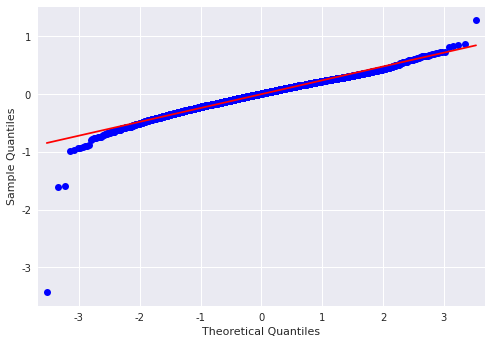

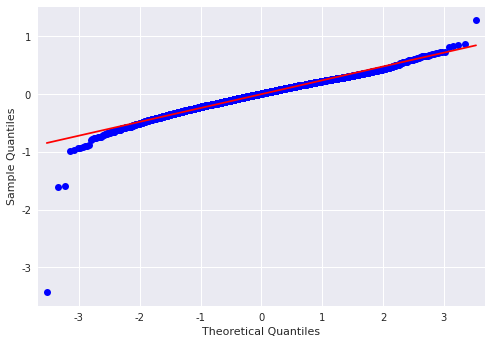

In [52]:
model_residuals = model_trained.resid

plt.rcParams['axes.unicode_minus'] = False
sm.ProbPlot(model_residuals).qqplot(line='s')

빨간색 선을 잘 따라가는 것으로 보아 확률 오차가 정규성을 잘 따르는 것으로 볼 수 있음.

## 3. 등분산성(오차의 분산이 일정한지) 판단

Text(0, 0.5, 'residuals')

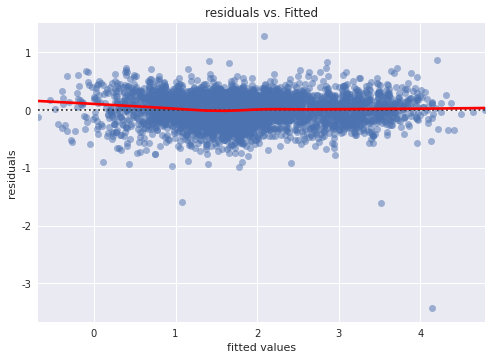

In [53]:
model_fitted_y = model_trained.fittedvalues

sns.residplot(model_fitted_y, y_train, data=X_train, lowess=True, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

plt.title('residuals vs. Fitted')
plt.xlabel('fitted values')
plt.ylabel('residuals')

빨간색 선이 직선에 가까운 것으로 보아 등분산성이 어느 정도 만족한다고 할 수 있음.

## 4. 독립성(오차가 서로 독립인지) 판단

In [54]:
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
model = ols('log_price ~ log_Kilometers_Driven + Mileage + log_Engine + log_Power', data[num_feature])

res = model.fit()

pd.DataFrame({'feature': column, 'VIF': variance_inflation_factor(model.exog, i)} 
             for i, column in enumerate(model.exog_names)
             if column != 'Intercept')

,feature,VIF
0,log_Kilometers_Driven,1.088236
1,Mileage,1.696529
2,log_Engine,5.315643
3,log_Power,4.609760


모든 VIF가 10미만으로 다중공선성 문제가 없음을 확인할 수 있음.